In [ ]:
import pandas as pd
import numpy
import os

import nltk

import torch
!pip install transformers
import transformers

     |████████████████████████████████| 2.1MB 5.6MB/s 
     |████████████████████████████████| 901kB 37.5MB/s 
     |████████████████████████████████| 3.3MB 40.8MB/s 


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

import torch
if torch.cuda.is_available():       
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving FA18_sentences.xlsx to FA18_sentences.xlsx


In [ ]:
df_fall_18_messages = pd.read_excel('FA18_sentences.xlsx', index_col=0)
print(df_fall_18_messages.shape)
df_fall_18_messages.head()

(6354, 2)


,Sentence,Recipient Gender
0,Hey @Katie Poteet I know you said we should em...,1
1,I’m planning to do the Baltimore Community Too...,1
2,@Mary Cassell I would email Dr. K anyway with ...,1
3,"If not, it’s still good for her to know what y...",1
4,"Ok, thanks a lot.",1


In [ ]:
# Get the lists of sentences and their labels.
sentences = df_fall_18_messages['Sentence'].values
labels = df_fall_18_messages['Recipient Gender'].values

In [ ]:
# Initialize the tokenizer with a pretrained model
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Convert the string "granola bars" to tokenized vocabulary IDs
sentence_ids = df_fall_18_messages['Sentence'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
print(sentence_ids[0])

[101, 4931, 1030, 9734, 8962, 15558, 1045, 2113, 2017, 2056, 2057, 2323, 10373, 3460, 23686, 2007, 1996, 6951, 4495, 2057, 2359, 2021, 2054, 2065, 2017, 2123, 1521, 1056, 2031, 1037, 3563, 3058, 2017, 2215, 2000, 2079, 2664, 1029, 102]


In [ ]:
max_len = 0
for id_vector in sentence_ids.values:
    if len(id_vector) > max_len:
        max_len = len(id_vector)

padded_ids = numpy.array([i + [0]*(max_len-len(i)) for i in sentence_ids.values])
print("max id array length: ", max_len)

max id array length:  105


In [ ]:
attention_mask = numpy.where(padded_ids != 0, 1, 0)
print(attention_mask.shape)

(6354, 105)


In [ ]:
# Convert lists to tensors
ids_tensor = torch.LongTensor(padded_ids)
attention_masks_tensor = torch.tensor(attention_mask)

In [ ]:
ids_batches = torch.tensor_split(ids_tensor, 100)
attention_masks_batches = torch.tensor_split(attention_masks_tensor, 100)

In [ ]:
model = transformers.BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
# Set the device to GPU (cuda) if available, otherwise stick with CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
'''
model_output: BaseModelOutputWithPoolingAndCrossAttentions
      last_hidden_state (torch.FloatTensor of shape (batch_size, sequence_length, hidden_size)) – Sequence of hidden-states at the 
      output of the last layer of the model.

      pooler_output (torch.FloatTensor of shape (batch_size, hidden_size)) – Last layer hidden-state of the first token of the 
      sequence (classification token) further processed by a Linear layer and a Tanh activation function. 
      The Linear layer weights are trained from the next sentence prediction (classification) objective during pretraining.

      hidden_states (tuple(torch.FloatTensor), optional, returned when output_hidden_states=True is passed or when 
      config.output_hidden_states=True) – Tuple of torch.FloatTensor (one for the output of the embeddings + one for the output 
      of each layer) of shape (batch_size, sequence_length, hidden_size).Hidden-states of the model at the output of each 
      layer plus the initial embedding outputs.

https://huggingface.co/transformers/main_classes/output.html
'''

embeddings = []
for i in range(0,len(ids_batches)):
  with torch.no_grad():
    ids_batch = ids_batches[i].to(device)
    attention_masks_batch = attention_masks_batches[i].to(device)
    model_output = model(ids_batch, attention_mask=attention_masks_batch)
    # Get last hidden state from tuple returned from model
    last_hidden_state = model_output[2][-2].cpu()
    
    # For each sentence in a batch
    for sentence in last_hidden_state: 
      # Get emmbedding for first token ([CLS])
      embeddings.append(sentence[0])
    
    ids_batch.cpu()
    attention_masks_batch.cpu()
    del model_output, ids_batch, attention_masks_batch
    torch.cuda.empty_cache()

In [ ]:
print("len(embeddings): ",len(embeddings))
print("embeddings[0].shape: ",embeddings[0].shape)

len(embeddings):  6354
embeddings[0].shape:  torch.Size([768])


In [ ]:
numpy_array = []
for embedding in embeddings:
  numpy_array.append(embedding.numpy())

X = numpy.array(numpy_array)
y = df_fall_18_messages["Recipient Gender"]

In [ ]:
df_features = pd.DataFrame(X)
df_features.sample(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
3991,0.946737,0.615987,-0.062655,-0.422720,-0.570069,-0.556639,0.166606,0.667584,0.251747,-0.088561,0.102786,-0.658925,-0.673646,0.314967,-0.322616,0.011547,-0.101706,0.468407,0.565593,-0.426343,-0.584400,0.341626,-0.287197,-0.045171,0.083149,-0.041980,0.262129,0.082882,-0.719182,-0.037517,0.337650,0.585640,-1.041052,0.283046,-0.203311,0.373581,0.124711,-0.389879,-0.866210,0.758392,...,-0.368021,0.278059,-0.494770,0.391099,-0.385028,-0.104859,0.251062,-0.274931,-0.088616,-0.762870,-0.345228,0.168834,-0.212961,0.280636,0.362201,0.111459,0.079426,0.355169,-0.253544,0.025913,-0.089342,-0.215889,-0.548181,-0.511287,-0.728605,0.166225,-0.097579,-0.086188,-0.091222,-0.108447,-0.292344,0.161118,0.142828,0.151750,-0.242049,0.031892,-0.438703,-0.046292,0.040638,0.006964
2184,-0.172090,0.368042,-0.148227,-0.504638,-0.602595,-0.477213,0.297587,0.540707,0.352251,-0.132289,0.280684,-0.279685,0.244642,0.194942,0.189104,0.038885,-0.182448,0.143422,-0.268854,0.192966,0.441930,-0.019482,-0.175646,-0.647143,0.237401,-0.197619,0.257519,-0.322917,-0.448483,0.720134,-0.213767,0.038366,-0.295409,0.029447,0.085402,0.201115,0.167187,-0.337227,-0.220930,-0.421747,...,-0.108965,-0.662702,0.013749,0.394550,-0.775542,-0.213564,0.127476,-0.198312,-0.112293,-0.054897,-0.185820,0.787926,-0.276313,-0.352525,0.036984,0.084367,0.161998,-0.251169,-0.072294,-0.182807,-0.137924,0.032230,0.301975,0.171926,-0.552041,0.329698,-0.145705,-0.109724,-0.078106,-0.855241,-0.120729,0.085098,-0.474727,-0.563760,-0.115081,0.061558,-0.203095,-0.263529,-0.083916,0.224013
5410,-0.027746,0.218243,-0.108347,-0.273950,-0.093948,-0.887207,0.468070,0.554923,-0.011596,-0.367588,0.704678,-0.466153,-0.172285,0.329357,-0.425738,-0.148867,-0.892581,0.367931,0.498470,-0.465250,-0.553992,-0.280599,-0.617907,-0.211747,0.114358,0.075127,0.012468,0.048244,-0.848347,0.147120,0.467860,0.065393,-0.144013,0.356512,0.228654,-0.125844,-0.075697,0.247874,-0.073276,0.263853,...,0.109732,-0.499063,0.199703,0.491439,-0.011008,0.780784,0.046107,-0.134418,0.005783,-0.196234,0.092370,0.107678,0.119780,0.720452,-0.390850,-0.004050,0.038416,0.189642,-0.006330,-0.147473,-0.704762,0.593964,-0.091526,-0.282464,-0.437977,-0.066464,0.397840,-0.176023,-0.524260,-0.036864,0.066931,-0.504183,-0.381945,-0.447457,0.004339,-0.135097,0.096461,-0.299831,-0.015523,0.934843
380,0.380478,0.156834,0.270485,-0.231957,-0.209088,-0.264098,0.508971,0.703675,0.241934,-0.149575,0.084263,-0.230792,0.068060,0.155241,0.050979,-0.200621,-0.603694,0.772507,-0.043041,0.017156,-0.089367,0.016249,0.456072,0.146305,0.592074,0.051648,-0.197282,0.237343,-0.550878,0.358475,-0.216457,0.290156,-0.373818,0.056631,0.322438,0.284070,0.045270,0.064151,-0.051373,0.130797,...,0.327063,-0.597112,-0.157626,0.665859,-0.644250,-0.195818,-0.049149,-0.319883,-0.716589,-0.616868,0.123155,0.202849,-0.078745,0.264753,-0.479162,0.445385,-0.232126,-0.072300,0.143098,-0.248555,-0.100468,0.370970,0.173286,0.173842,-0.567376,0.417312,0.063144,0.567223,-0.232021,-0.345584,-0.443574,-0.252898,-0.401061,-0.218557,0.205161,-0.130115,0.181649,0.016897,-0.278333,0.069859
4363,0.066209,0.519197,0.414799,-0.087631,-0.095288,-0.772382,0.401931,0.832975,0.490071,-0.509794,0.374448,-0.057841,0.543839,0.067088,-0.406424,-0.791742,-0.286779,0.738740,0.111629,-0.024658,-0.159116,-0.107611,-0.086792,-0.162574,0.247150,-0.326127,-0.559380,-0.102287,-0.108626,0.479306,0.389244,-0.068275,-0.852764,0.445810,0.210808,-0.088143,0.836093,-0.022847,-0.229246,0.262412,...,0.466158,-0.609052,0.143607,0.248193,-0.528763,0.071541,-0.277072,-0.464171,0.077304,-0.159536,0.128829,0.580398,-0.560200,0.231158,-0.439513,0.650774,-0.302992,-0.188758,-0.344884,0.285887,-0.254916,0.417936,-0.401107,0.089283,-0.815267,0.018022,0.

In [ ]:
# Train/Test splitting
from sklearn import model_selection

# Hyper-parameter tuning
from sklearn.model_selection import RandomizedSearchCV,  GridSearchCV, cross_val_score

# Classifiers
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Classifier evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer, confusion_matrix, classification_report

# Print confusion matrix
import seaborn as sns

In [ ]:
# Print y shape, head, unique values and number of instances in each class
print(y.shape)
print(y.unique())
print(y.value_counts())

# split into training and test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6354,)
[1 2 0]
2    2918
1    1794
0    1642
Name: Recipient Gender, dtype: int64
(5083, 768)
(5083,)
(1271, 768)
(1271,)


In [ ]:
def get_best_estimator(clf, params):
    # Metrics to use for optimization
    # metrics = ['accuracy','f1', 'f1_macro', 'f1_weighted','precision','recall']
    
    # Optimize based on f1_macro score
    grid_search = GridSearchCV(clf, param_grid = params, cv = 3, n_jobs = -1, scoring = 'f1_macro', verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Get estimator with best parameter valuese
    best_estimator = grid_search.best_estimator_
    print(best_estimator)
    
    # Return best_estimator
    return best_estimator

In [ ]:
def print_results(clf, y_pred):
    # Print accuracy score 
    print("Accuracy Score -> ",accuracy_score(y_pred, y_test)*100)
    
    # Print confusion matrix (heat map)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
    print(classification_report(y_test, y_pred))
    
    # Print avarage 10-fold cross validation accuracy and f1 scores 
    #svm_cv_accuracy_score = cross_val_score(clf, X_train, y_train, cv=10,scoring='accuracy')
    #svm_cv_f1_score = cross_val_score(clf, X_train, y_train, cv=10,scoring='f1_macro')
    #print("Mean cv accuracy: ", svm_cv_accuracy_score.mean())
    #print("Mean cv f1_macro: ", svm_cv_f1_score.mean())

In [ ]:
def svm():
    # Parameters to optimize for svm
    param_grid = {'probability': [True],
                  'C': [1, 5, 10],
                  'kernel': ['rbf'],
                  'gamma': ['auto', 'scale', 0.1, 0.01, 0.001],
                 }
    # Get optimized parameters from grid search
    svm_clf = SVC()
    optimized_svm_clf = get_best_estimator(svm_clf, param_grid)
    optimized_svm_clf.fit(X_train, y_train)
    
    # predict recipient gender and print prediction results
    y_pred = optimized_svm_clf.predict(X_test)
    print_results(optimized_svm_clf, y_pred)

In [ ]:
def random_forest():
    # Parameters to optimize for rf
    param_grid = {
        'max_depth': [10, 50, 100],
        'min_samples_leaf': [3, 4],
        'min_samples_split': [3, 5],
        'n_estimators': [100, 200]
    }
    
    # Get optimized parameters from grid search
    rf_clf = RandomForestClassifier()
    optimized_rf_clf = get_best_estimator(rf_clf, param_grid)
    optimized_rf_clf.fit(X_train, y_train)
    
    # predict recipient gender and print prediction results
    y_pred = optimized_rf_clf.predict(X_test)
    print_results(optimized_rf_clf, y_pred)

In [ ]:
def mlp():
    # Parameters to optimize for rf
    param_grid = {
        'hidden_layer_sizes': [(100,50,10), (100, 50), (20,10,5)],
        'activation': ['tanh', 'relu'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.05],
        'max_iter': [500]
    }
    
    # Get optimized parameters from grid search
    mlp_clf = MLPClassifier()
    optimized_mlp_clf = get_best_estimator(mlp_clf, param_grid)
    optimized_mlp_clf.fit(X_train, y_train)
    
    # predict recipient gender and print prediction results
    y_pred = optimized_mlp_clf.predict(X_test)
    print_results(optimized_mlp_clf, y_pred)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 15.5min finished


SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Accuracy Score ->  53.81589299763966
              precision    recall  f1-score   support

           0       0.40      0.29      0.34       344
           1       0.44      0.41      0.42       340
           2       0.63      0.76      0.69       587

    accuracy                           0.54      1271
   macro avg       0.49      0.49      0.48      1271
weighted avg       0.52      0.54      0.52      1271



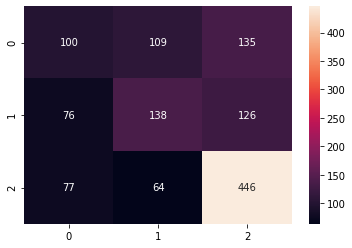

In [ ]:
svm()

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  3.7min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy Score ->  53.186467348544454
              precision    recall  f1-score   support

           0       0.43      0.12      0.19       344
           1       0.43      0.34      0.38       340
           2       0.57      0.88      0.70       587

    accuracy                           0.53      1271
   macro avg       0.48      0.45      0.42      1271
weighted avg       0.50      0.53      0.47      1271



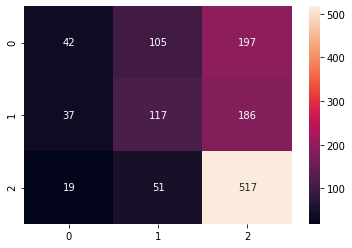

In [ ]:
random_forest()

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.9min finished


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Accuracy Score ->  50.19669551534225
              precision    recall  f1-score   support

           0       0.34      0.31      0.33       344
           1       0.38      0.42      0.40       340
           2       0.66      0.66      0.66       587

    accuracy                           0.50      1271
   macro avg       0.46      0.46      0.46      1271
weighted avg       0.50      0.50      0.50      1271



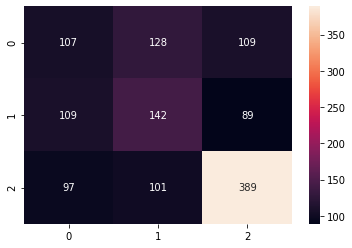

In [ ]:
mlp()